# Ordinary Least Squares in Statsmodels (OLS) - Lab

## Introduction

In the previous Codealong, you looked at all the requirements for running an OLS simple regression using Statsmodels. You worked with the height-weight data to understand the process and all the necessary steps that must be performed. In this lab , you'll explore slightly more complex example to study the impact of spendings in different advertising channels of total sales.

## Objectives

You will be able to:
* Set up an analytical question to be answered by regression analysis
* Study regression assumptions for real world datasets
* Visualize the results of regression analysis

## Let's get started

In this lab, you'll work with the "Advertising Dataset", which is a very popular dataset for studying simple regression. [The dataset is available on Kaggle](https://www.kaggle.com/purbar/advertising-data), but we have downloaded it for you. It is available in this repository as `advertising.csv`. You'll use this dataset to answer this question:

> Which advertising channel has the strongest relationship with sales volume, and can be used to model and predict the sales?

## Step 1: Read the dataset and inspect its columns and 5-point statistics

In [2]:
# Load necessary libraries and import the data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
import seaborn as sns

In [3]:
# Check the columns and first few rows
# Check the columns and first few rows
df = pd.read_csv('Advertising.csv', index_col=0)
df.head()

,TV,radio,newspaper,sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


In [4]:
# Get the 5-point statistics for data 
df.describe()

,TV,radio,newspaper,sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,14.022500
std,85.854236,14.846809,21.778621,5.217457
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,10.375000
50%,149.750000,22.900000,25.750000,12.900000
75%,218.825000,36.525000,45.100000,17.400000
max,296.400000,49.600000,114.000000,27.000000


### Describe the contents of this dataset
There are 200 observations, all numerical values, no missing values.
TV mean and mode are similar and likely normallly distributed since range is 300-0, Quantile range is 75-218. 
Radio 0-50 range, mean and mode similar but quantile suggests more towards lower end (may be some outliers in the higher range). Newspaper very much skewed lower, since 0-114 max, but mean and mode are 30, 25. and quantile range is 12-45. May need to be aware of those outliers. Sales also not too made. might be easier to plot it since comparing mean and modes and quantile ranges are close but not the same.

## Step 2: Plot histograms with kde overlay to check the distribution of the predictors

/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


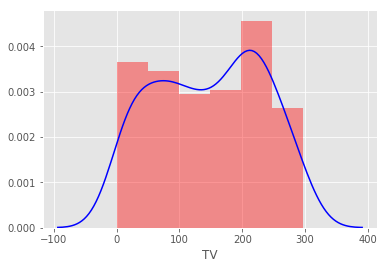

In [5]:
# For all the variables, check distribution by creating a histogram with kde
plt.style.use('ggplot')
sns.distplot(df['TV'], color='red', kde_kws={'color': 'blue'})

/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


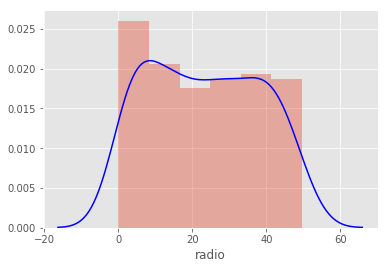

In [6]:
sns.distplot(df['radio'], kde_kws={'color': 'blue'})

/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


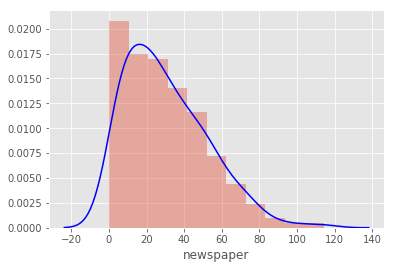

In [7]:
sns.distplot(df['newspaper'], kde_kws={'color': 'blue'})

/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


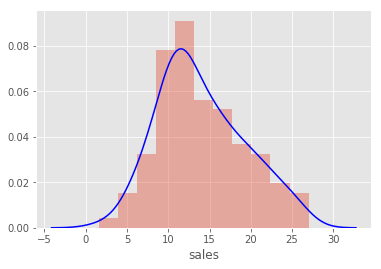

In [8]:
sns.distplot(df['sales'], kde_kws={'color': 'blue'});

#### Observations
As suspected, newspaper is very much skewed right (long tail at upper end)
however they are not outliers it seems gradual enough. 
TV and Radio seem to have two peaks, but overall fairly normal


## Step 3: Test for the linearity assumption 

Use scatterplots to plot each predictor against the target variable

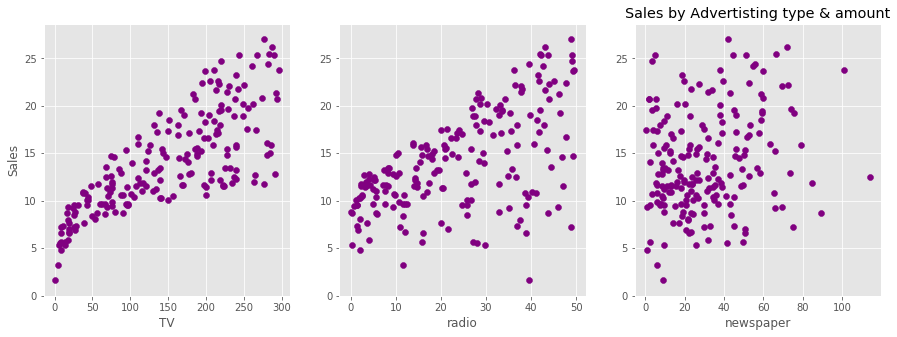

In [9]:
# visualize the relationship between the preditors and the target using scatterplots
fig = plt.figure(figsize=[15,5])
ax = fig.add_subplot(131)
ax.scatter(df['TV'], df['sales'], c='purple')
plt.ylabel('Sales')
ax.set_xlabel('TV')
ax1 = fig.add_subplot(132, sharey=ax)
ax1.scatter(df['radio'], df['sales'], c='purple')
ax1.set_xlabel('radio')
ax2 = fig.add_subplot(133, sharey=ax)
ax2.scatter(df['newspaper'], df['sales'], c='purple')
ax2.set_xlabel('newspaper')
plt.title("Sales by Advertisting type & amount")
plt.show()

#### Record yor observations on linearity here 
TV looks somewhat lineary, higher ranges start to spread out. Some linear trend in radio but also varied. some high end on the radio scale has very low sales. 
Newspapers seems to be all over the place and not linear, perhaps not even correlated.

### Conclusion so far

Based on above initial checks, we can confidently say that TV and radio appear to be good predictors for our regression analysis. Newspaper is very heavily skewed and also doesnt show any clear linear relationship with the target. 
> We'll move ahead with our analysis using TV and radio, and rule out newspaper because we believe it violates OLS assumptions

Note: Kurtosis can be dealt with using techniques like log normalization to "push" the peak towards the center of distribution. You'll learn about this later on.

## Step 4: Run a simple regression in Statsmodels with TV as a predictor

In [10]:
# build the formula 
f = 'sales~TV'

# create a fitted model in one line
model = ols(formula=f, data=df).fit()


## Step 5: Get Regression Diagnostics Summary

In [11]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     312.1
Date:                Sat, 13 Jul 2019   Prob (F-statistic):           1.47e-42
Time:                        12:40:21   Log-Likelihood:                -519.05
No. Observations:                 200   AIC:                             1042.
Df Residuals:                     198   BIC:                             1049.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.0326      0.458     15.360      0.000       6.130       7.935
TV             0.0475      0.003     17.668      0.000       0.042       0.053
==============================================================================
Omnibus:                        0.531   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.767   Jarque-Bera (JB):                0.669
Skew:                          -0.089   Prob(JB):                        0.716
Kurtosis:                       2.779   Cond. No.                         338.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Note here that the coefficients represent associations, not causations

## Step 6:  Draw a prediction line with data points on a scatter plot for X (TV) and Y (Sales)

Hint: You can use the `model.predict()` function to predict the start and end point of of regression line for the minimum and maximum values in the 'TV' variable. 

      TV  Prediction
0    0.7    7.065869
1  296.4   21.122454


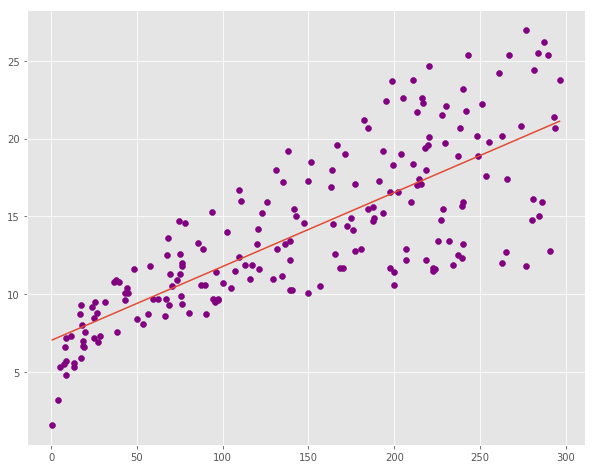

In [17]:
# create a DataFrame with the minimum and maximum values of TV
# make predictions for those x values and store them
min_max_df = pd.DataFrame(data={'TV': [df.TV.min(), df.TV.max()]})
min_max_df['Prediction'] = model.predict(min_max_df)
print(min_max_df)

# first, plot the observed data and the least squares line
fig = plt.figure(figsize=[10,8])
ax = fig.add_subplot(111)
ax.scatter(df['TV'], df['sales'], c='purple')
ax.plot(min_max_df['TV'], min_max_df['Prediction'])
plt.show()

## Step 7: Visualize the error term for variance and heteroscedasticity

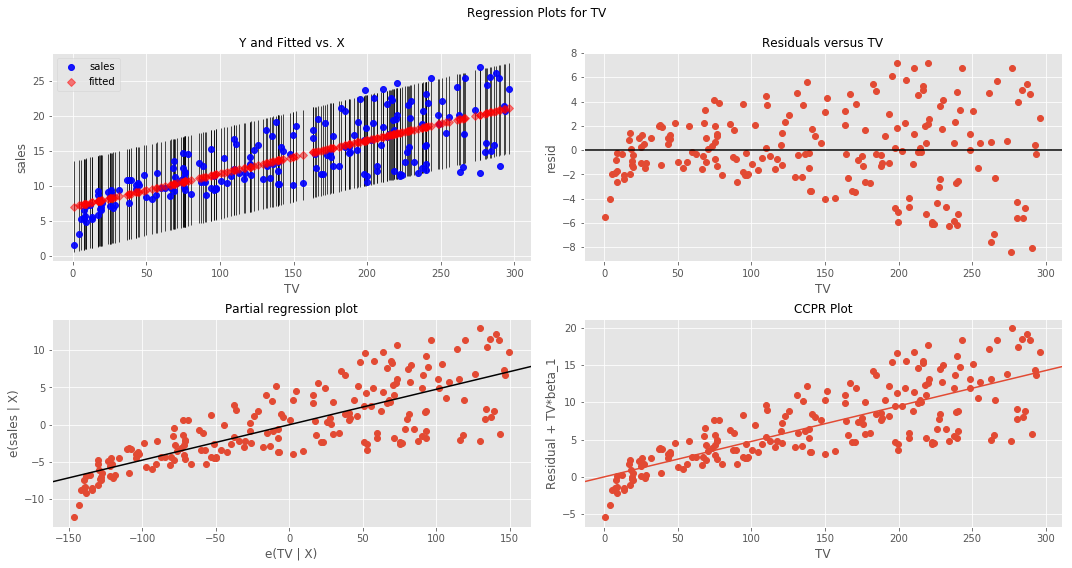

In [19]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "TV", fig=fig)
plt.show()

#### Record Your observations on heteroscedasticity
Plot above (scatter plot) shows that TV sales have cone line shape and scatter wider as it goes up. So the data is heteroscedastic and breaks the assumptions for linear regression. The residual plot also shows the heterodastic tendency

## Step 8: Check the normality assumptions by creating a QQ-plot

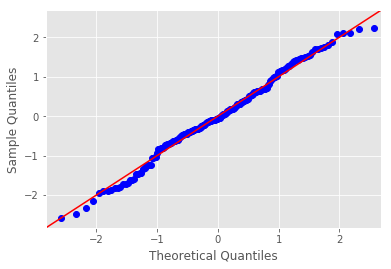

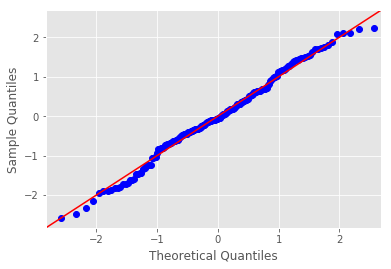

In [20]:
# Code for QQ-plot here
residuals = model.resid
sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)

#### Record Your observations on the normality assumption
Fairly normal distribution - normality assumption holds.

## Step 9: Repeat the above for radio and record your observations

In [ ]:
# code for model, prediction line plot, heteroscedasticity check and QQ normality check here

In [77]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.332
Model:                            OLS   Adj. R-squared:                  0.329
Method:                 Least Squares   F-statistic:                     98.42
Date:                Fri, 12 Oct 2018   Prob (F-statistic):           4.35e-19
Time:                        20:52:55   Log-Likelihood:                -573.34
No. Observations:                 200   AIC:                             1151.
Df Residuals:                     198   BIC:                             1157.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.3116      0.563     16.542      0.000       8.202      10.422
radio          0.2025      0.020      9.921      0.000       0.162       0.243
==============================================================================
Omnibus:                       19.358   Durbin-Watson:                   1.946
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.910
Skew:                          -0.764   Prob(JB):                     1.75e-05
Kurtosis:                       3.544   Cond. No.                         51.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [79]:
# Record your observations here for goodnes of fit 

## The Answer

Based on above analysis, you can conclude that none of the two chosen predictors is ideal for modeling a relationship with the sales volumes. `Newspaper` clearly violated the linearity assumption. `TV` and `radio` did not provide a high value for the coefficient of determination, where TV performed slightly better than the radio. There is obvious heteroscdasticity in the residuals for both variables. 

> We can either look for further data, perform extra preprocessing or use more advanced techniques. 

Remember there are lots of technqiues we can employ to fix these data. 

Whether we should call TV the "best predictor" or label all of them "equally useless", is a domain specific question and a marketing manager would have a better opinion on how to move forward with this situation. 

In the following lesson, you'll look at the more details on interpreting the regression diagnostics and confidence in the model. 

## Summary

In this lab, you ran a complete regression analysis with a simple dataset. You looked for the regression assumptions before and after the analysis phase. We also created some visualizations to develop a confidence on the model and check for its goodness of fit. 